In [1]:
import numpy as np
import pandas as pd
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
!pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D
!pip install torch-summary
import cv2

  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /tmp/pip-req-build-2a2x14qv
  Running command git clone -q https://github.com/shijianjian/EfficientNet-PyTorch-3D /tmp/pip-req-build-2a2x14qv
  Resolved https://github.com/shijianjian/EfficientNet-PyTorch-3D to commit 3e79bcd06216b2e831bf3300fff9636cce2cd0d1
  Created wheel for efficientnet-pytorch-3d: filename=efficientnet_pytorch_3d-0.6.3-py3-none-any.whl size=16770 sha256=377cd30a65b9473af4c1bdc3bf5756714932b2ad05f928c0dd851b8e5024226c
  Stored in directory: /tmp/pip-ephem-wheel-cache-m5xqnrul/wheels/ea/44/3d/89ce0e32ed262cff6c10d0586dc8f82bbb8ba1eeb47863abe5
Successfully built efficientnet-pytorch-3d


In [2]:
#Organisers have said these are to be ignored
exclude = [109, 123, 709]
train_csv = pd.read_csv('/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
train_csv = train_csv[~train_csv.BraTS21ID.isin(exclude)]

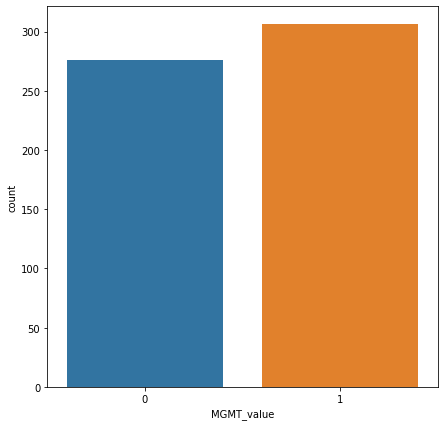

In [3]:
plt.figure(figsize=(7, 7))
sns.countplot(data=train_csv, x="MGMT_value");

In [4]:
NUM_IMAGES = 64
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256

#https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way

def load_dicom(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    
    data = cv2.resize(data, (SIZE, SIZE))
    data = data.astype(np.float64)
        
    return data

#loads 64 (SIZE) images from a DICOM file from a single MRI type
def load_dicom_3d(brats21id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", data_split="train"):
    patient_path = os.path.join(f"/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/{data_split}/", str(brats21id).zfill(5))
    x = glob.glob(os.path.join(patient_path, mri_type, "*"))
    paths = sorted(x, key=lambda x: int(x[:-4].split("-")[-1]))
    
    middle = len(paths) // 2
    num_imgs2 = num_imgs // 2
    bottom = max(0, middle - num_imgs2)
    top = min(len(paths), middle + num_imgs2)
    
    image_3d = np.stack([load_dicom(f) for f in paths[bottom:top]]).transpose()
    
    if image_3d.shape[-1] < num_imgs:
        zero_padding = np.zeros((img_size, img_size, abs(num_imgs - image_3d.shape[-1])))
        image_3d = np.concatenate((image_3d, zero_padding), axis=-1)
    
    #normalise data
    if np.min(image_3d) < np.max(image_3d):
        image_3d = image_3d - np.min(image_3d)
        image_3d = image_3d / np.max(image_3d)
    return np.expand_dims(image_3d, 0)

In [5]:
a = load_dicom_3d(106)
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 256, 256, 64)
0.0 1.0 0.06492401325182892 0.0


In [6]:
# Displays the middle sample of each MRI type for an ID
def visualise_sample(brats21id, mgmt_value, types=("FLAIR", "T1w", "T1wCE", "T2w")):
    plt.figure(figsize=(16, 5)) 
    patient_path = os.path.join("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train/", str(brats21id).zfill(5))
    for i, type in enumerate(types, 1):
        x = glob.glob(os.path.join(patient_path, type, "*"))
        type_paths = sorted(glob.glob(os.path.join(patient_path, type, "*")), key=lambda x: int(x[:-4].split("-")[-1]))
        data = load_dicom(type_paths[(len(type_paths) // 2)])
        plt.subplot(1, 4, i)
        plt.imshow(data, cmap="gray")
        plt.title(f"{type}", fontsize=16)

    plt.suptitle(f"BraTS21ID: {brats21id}  MGMT_value: {mgmt_value}", fontsize=16)
    plt.show()

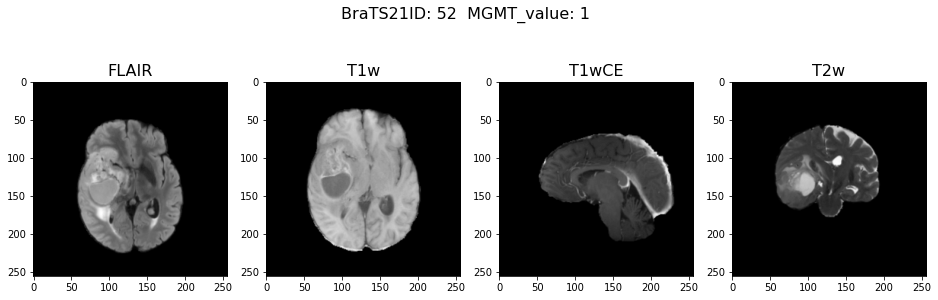

In [7]:
random_sample = train_csv.sample(n=1).values
random_sample_ID = random_sample[0][0]
random_sample_MGMT = random_sample[0][1]
visualise_sample(random_sample_ID, random_sample_MGMT)

In [8]:
efficientnet_path = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"

from efficientnet_pytorch_3d import EfficientNet3D

import torch
from torch import nn
torch.set_default_dtype(torch.float64)

#dataset splitting
from sklearn import model_selection as sk_model_selection

#convolutional
from torch.nn import functional as torch_functional

In [9]:
train, valid = sk_model_selection.train_test_split(train_csv, random_state=3220, stratify=train_csv["MGMT_value"],)
print(train)

     BraTS21ID  MGMT_value
62          98           1
170        251           0
365        539           1
566        830           0
489        714           1
..         ...         ...
541        794           1
181        269           0
120        183           0
162        241           0
157        236           0

[436 rows x 2 columns]


In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_IDs, targets, mri_type, split="train"):
        self.image_IDs = image_IDs
        self.targets = targets
        self.mri_type = mri_type
        self.split = split
        
    def __len__(self):
        return len(self.image_IDs)
    
    def __getitem__(self, i: int):
        image_num = self.image_IDs[i]
        #targets is None when not dealing with a train split
        if self.targets is not None:
            data = load_dicom_3d(image_num)
        else:
            data = load_dicom_3d(image_num, split=self.split)
        
        if self.targets is not None:
            return {"X": data, "y": torch.tensor(self.targets[i], dtype=torch.float64)}
        else:
            return {"X": torch.tensor(data, dtype=torch.float64), "id": image_num}

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #create a network using efficientnet-b0, that has 2 output classes (MGMT 1/0) and 1 input channel as it is greyscale
        self.network = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        #classifier
        self.network._fc = nn.Linear(in_features=self.network._fc.in_features, out_features=1, bias=True)
        
    def forward(self, x):
        out = self.network(x)
        return out

In [12]:
import time
from sklearn.metrics import roc_auc_score
class Trainer:
    def __init__(self, model, device, optimizer, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        
    def fit(self, epochs, train_loader, valid_loader):
        for epoch_n in range(1, epochs + 1):
            print(f"Epoch {epoch_n}")
            train_loss = self.train_one_epoch(train_loader)
            valid_loss = self.validate_one_epoch(valid_loader)
            print("Training loss: ", train_loss)
            print("Validation loss: ", valid_loss)
                    
    def train_one_epoch(self, train_dataloader):
        sum_loss = 0
        self.model.train()
        time_start = time.time()
        for step, batch in enumerate(train_dataloader, 1):
            print("Step: ", step, end='\r')
            ids = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(ids).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()

            self.optimizer.step()
        print(time.time() - time_start)
        return sum_loss/len(train_dataloader)
    
    def validate_one_epoch(self, valid_dataloader):
        #set model up for evaluation, disables dropout layers etc.
        self.model.eval()
        sum_loss = 0
        all_outputs = []
        all_targets = []
        time_start = time.time()
        for step, batch in enumerate(valid_dataloader, 1):
            #deactivate autograd
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)
                
                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)
                
                sum_loss += loss.detach().item()
                all_targets.extend(batch["y"].tolist())
                all_outputs.extend(torch.sigmoid(outputs).tolist())
                
        for x in all_targets:
            if x > 0.5:
                x = 1
            else:
                x = 0
        auc = roc_auc_score(all_targets, all_outputs)
        print("Time: ", time.time() - time_start, "AUC: ", auc)
        return sum_loss/len(valid_dataloader)  

In [13]:
from torchsummary import summary

def train_model(train, valid, mri_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_dataset = Dataset(
        train["BraTS21ID"].values, 
        train["MGMT_value"].values, 
        "FLAIR"
    )

    train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2,pin_memory = True
    )
    
    valid_dataset = Dataset(
        valid["BraTS21ID"].values, 
        valid["MGMT_value"].values, 
        "FLAIR"
    )

    valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=2,pin_memory = True
    )
    
    model = Model()
    model.to(device)
    summary(model, input_size=(1, 256, 256, 64))
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(model, device, optimiser, criterion)
    history = trainer.fit(10, train_loader, valid_loader)
    
    

In [14]:
train_model(train, valid, "FLAIR")

Layer (type:depth-idx)                                  Param #
├─EfficientNet3D: 1-1                                   --
|    └─Conv3dStaticSamePadding: 2-1                     --
|    |    └─ZeroPad2d: 3-1                              --
|    └─BatchNorm3d: 2-2                                 64
|    └─ModuleList: 2-3                                  --
|    |    └─MBConvBlock3D: 3-2                          2,024
|    |    └─MBConvBlock3D: 3-3                          7,732
|    |    └─MBConvBlock3D: 3-4                          13,302
|    |    └─MBConvBlock3D: 3-5                          29,750
|    |    └─MBConvBlock3D: 3-6                          55,290
|    |    └─MBConvBlock3D: 3-7                          41,450
|    |    └─MBConvBlock3D: 3-8                          111,540
|    |    └─MBConvBlock3D: 3-9                          111,540
|    |    └─MBConvBlock3D: 3-10                         174,004
|    |    └─MBConvBlock3D: 3-11                         275,772
|    |   